In [1]:
%pylab
%matplotlib inline
from thermocouples_reference import thermocouples

k_type = thermocouples['K']

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [54]:
class Thermocouple(object):
    def __init__(self, r1=10e3, r2=464.5e3, rtc=29.0, vref=40e-3, vdd=3.3):
        self.r1 = r1
        self.r2 = r2
        self.rtc = rtc
        self.vref = vref
        self.vdd = vdd

    @property
    def c2(self):
        return (self.r2 / self.r1)

    @property
    def c3(self):
        return (self.r1 + self.rtc + self.r2) / self.rtc

    def it(self, vout):
        return (vout - self.vt(vout)) / (self.r1 + self.r2)

    def vt(self, vout):
        return self.vref - vout / self.c2

    def vto(self, vout):
        return self.vt(vout) - self.it(vout) * self.rtc

class Thermistor(object):
    def __init__(self, r0=100000, beta=3950, t0=298.15, r_sense=67000 * 2):
        self.r0 = r0 # Ohm
        self.beta = beta
        self.t0 = t0 # Kelvin
        self.r_sense = r_sense # Ohm

        self.r_inf = self.r0 * numpy.e ** -(self.beta / self.t0)

    def temp(self, v_adc):
        """
        Accept ADC value from thermistor connected to ADC_IN0.
        Return temperature in Kelvin
        """
        return self.beta / numpy.log(
            self.r_sense / self.r_inf * (float(0xfff) / v_adc - 1)
        )

In [55]:
cold_junction_thermistor = Thermistor()

adc_clicks = np.arange(400, 4000, 1)
k_type_temp2v = np.vectorize(k_type.func)
cold_junction_adc2mv = k_type_temp2v(cold_junction_thermistor.temp(adc_clicks)-273.15)

In [60]:
index = np.argmax(adc_clicks==2394)
print cold_junction_thermistor.temp(2394)-273.15
print cold_junction_adc2mv[index]

26.1086287066
1.04518371242


[(400, -87607),
 (454, -78964),
 (513, -70306),
 (576, -61773),
 (644, -53219),
 (718, -44528),
 (797, -35817),
 (882, -26966),
 (974, -17872),
 (1052, -10480),
 (1135, -2872),
 (1225, 5133),
 (1323, 13627),
 (1509, 29306),
 (1981, 68385),
 (2112, 79489),
 (2229, 89648),
 (2351, 100570),
 (2463, 110977),
 (2568, 121146),
 (2667, 131179),
 (2762, 141296),
 (2851, 151295),
 (2935, 161282),
 (3015, 171382),
 (3090, 181467),
 (3161, 191666),
 (3228, 201977),
 (3292, 212564),
 (3332, 219607),
 (3370, 226644),
 (3407, 233861),
 (3443, 241270),
 (3477, 248662),
 (3510, 256249),
 (3542, 264044),
 (3572, 271795),
 (3601, 279748),
 (3629, 287914),
 (3656, 296303),
 (3681, 304582),
 (3706, 313423),
 (3729, 322123),
 (3752, 331444),
 (3773, 340577),
 (3793, 349911),
 (3812, 359437),
 (3830, 369144),
 (3839, 374279),
 (3848, 379620),
 (3857, 385184),
 (3865, 390333),
 (3873, 395687),
 (3881, 401264),
 (3889, 407082),
 (3896, 412386),
 (3903, 417907),
 (3910, 423660),
 (3917, 429667),
 (3923, 435034

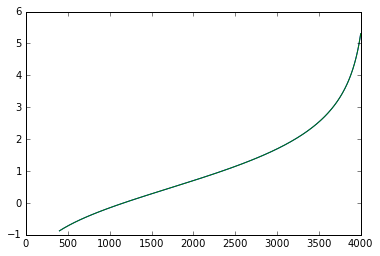

In [59]:
from rdp import rdp
from pprint import pprint

cold_junction_adc2mv_approx = rdp(zip(adc_clicks, cold_junction_adc2mv), epsilon=0.001)

pprint([(int(v[0]), int(v[1]*100000)) for v in cold_junction_adc2mv_approx])

plt.plot(adc_clicks, cold_junction_adc2mv)
plt.plot([v[0] for v in cold_junction_adc2mv_approx], [v[1] for v in cold_junction_adc2mv_approx])

In [29]:
hot_junction_temp = np.arange(-100, 1200, 0.01)
hot_junction_delta = k_type_temp2v(hot_junction_temp)
print 'Maximum hot junction voltage at 0C {}'.format(hot_junction_delta.max())
print 'Minimum hot junction voltage at 0C {}'.format(hot_junction_delta.min())

Maximum hot junction voltage at 0C 48.8378729949
Minimum hot junction voltage at 0C -3.55363133658


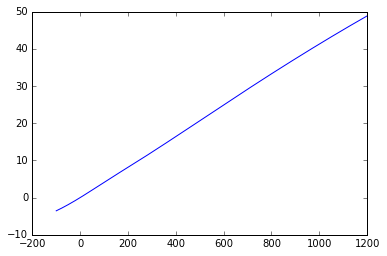

In [6]:
plt.plot(hot_junction_temp, hot_junction_delta)

In [9]:
def inverse_k_type(voltage):
    return k_type.func.inverse(voltage, None, 1e-6)
inverse_k_typev = np.vectorize(inverse_k_type)

In [34]:
hot_junction_voltage = np.arange(-6, 50, 0.001)
hot_junction_v2temp = inverse_k_typev(hot_junction_voltage)

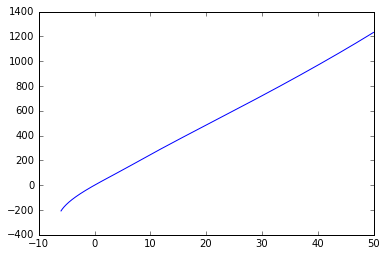

In [35]:
plt.plot(hot_junction_voltage, hot_junction_v2temp)

In [42]:
hot_junction_v2temp_approx = rdp(zip(hot_junction_voltage, hot_junction_v2temp), epsilon=0.01)
pprint([(int(v[0]*100000), int(v[1]*100000)) for v in hot_junction_v2temp_approx])

[(-600000, -20745761),
 (-583899, -19663385),
 (-565399, -18565988),
 (-544499, -17453017),
 (-521099, -16319743),
 (-495399, -15175797),
 (-467299, -14016022),
 (-403599, -11637114),
 (-330099, -9184684),
 (-245699, -6619551),
 (-149199, -3904806),
 (-38799, -990091),
 (117100, 2920661),
 (524800, 12802735),
 (970500, 23895984),
 (1250700, 30719361),
 (1467100, 35900951),
 (1708800, 41633726),
 (2516600, 60613122),
 (2838600, 68229597),
 (3182100, 76467347),
 (3504800, 84346050),
 (3711200, 89465637),
 (3914400, 94571026),
 (4113800, 99647162),
 (4307600, 104648324),
 (4492900, 109499150),
 (4669900, 114204326),
 (4838500, 118761147),
 (4999900, 123201957)]


In [43]:
3300000 * 0xfff



13513500000L